Set random seeds for reproducibility

In [1]:
import numpy as np
import random
import torch

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

# IMDB dataset load & split

In [2]:
!pip install datasets transformers gensim scikit-learn

from datasets import load_dataset
import pandas as pd

imdb = load_dataset("imdb")
train_df = pd.DataFrame(imdb['train'])
test_df = pd.DataFrame(imdb['test'])

# train (80%) and validation (20%)
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['label'])
print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Train: 20000, Val: 5000, Test: 25000


# Show first 5 rows of datasets

In [3]:
print("Train Dataset (First 5 rows):")
display(train_df.head(5))

print("\nValidation Dataset (First 5 rows):")
display(val_df.head(5))

print("\nTest Dataset (First 5 rows):")
display(test_df.head(5))

Train Dataset (First 5 rows):


,text,label
20022,I have always been a huge James Bond fanatic! ...,1
4993,I am a Christian and I say this movie had terr...,0
24760,"Neatly sandwiched between THE STRANGER, a smal...",1
13775,Years ago I did follow a soap on TV. So I was ...,1
20504,"Here's a gritty, get-the-bad guys revenge stor...",1



Validation Dataset (First 5 rows):


,text,label
15626,"That 70s Show is the best TV show ever, period...",1
18778,"This is a must see for independant movie fans,...",1
8927,"After watching this, I had lost a little respe...",0
3998,...through the similarly minded antics of Eric...,0
15287,Everything I remember about it was excellent.....,1



Test Dataset (First 5 rows):


,text,label
0,I love sci-fi and am willing to put up with a ...,0
1,"Worth the entertainment value of a rental, esp...",0
2,its a totally average film with a few semi-alr...,0
3,STAR RATING: ***** Saturday Night **** Friday ...,0
4,"First off let me say, If you haven't enjoyed a...",0


# Text preprocessing

In [4]:
import re
import string
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply preprocessing to all sets
train_df['text'] = train_df['text'].apply(preprocess_text)
val_df['text'] = val_df['text'].apply(preprocess_text)
test_df['text'] = test_df['text'].apply(preprocess_text)

# TF-IDF + Logistic Regression

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['text'])
X_val_tfidf = tfidf_vectorizer.transform(val_df['text'])
X_test_tfidf = tfidf_vectorizer.transform(test_df['text'])

y_train = train_df['label']
y_val = val_df['label']
y_test = test_df['label']

# Train Logistic Regression
lr_tfidf = LogisticRegression(max_iter=200, random_state=42)
lr_tfidf.fit(X_train_tfidf, y_train)

# Predict and evaluate on validation
y_val_pred_tfidf = lr_tfidf.predict(X_val_tfidf)
tfidf_val_acc = accuracy_score(y_val, y_val_pred_tfidf)
tfidf_val_prec = precision_score(y_val, y_val_pred_tfidf)
tfidf_val_rec = recall_score(y_val, y_val_pred_tfidf)
tfidf_val_f1 = f1_score(y_val, y_val_pred_tfidf)

# Predict and evaluate on test
y_test_pred_tfidf = lr_tfidf.predict(X_test_tfidf)
tfidf_test_acc = accuracy_score(y_test, y_test_pred_tfidf)
tfidf_test_prec = precision_score(y_test, y_test_pred_tfidf)
tfidf_test_rec = recall_score(y_test, y_test_pred_tfidf)
tfidf_test_f1 = f1_score(y_test, y_test_pred_tfidf)

print("TF-IDF Test Metrics: Acc:", tfidf_test_acc, "Prec:", tfidf_test_prec, "Rec:", tfidf_test_rec, "F1:", tfidf_test_f1)

TF-IDF Test Metrics: Acc: 0.87404 Prec: 0.8686430655207759 Rec: 0.88136 F1: 0.8749553270063137


# Word2Vec + Logistic Regression

In [6]:
!pip install gensim scikit-learn nltk

# Import libraries
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Download NLTK resources
nltk.download('punkt')  # For backward compatibility
nltk.download('punkt_tab')  # Explicitly download punkt_tab

# Tokenize texts
train_tokens = [word_tokenize(text) for text in train_df['text']]
val_tokens = [word_tokenize(text) for text in val_df['text']]
test_tokens = [word_tokenize(text) for text in test_df['text']]

# Train Word2Vec model
w2v_model = Word2Vec(sentences=train_tokens, vector_size=100, window=5, min_count=5, workers=4, seed=42)

# Function to get average Word2Vec embedding for a sentence
def get_w2v_embedding(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# Get embeddings
X_train_w2v = np.array([get_w2v_embedding(tokens, w2v_model) for tokens in train_tokens])
X_val_w2v = np.array([get_w2v_embedding(tokens, w2v_model) for tokens in val_tokens])
X_test_w2v = np.array([get_w2v_embedding(tokens, w2v_model) for tokens in test_tokens])

# Train Logistic Regression
lr_w2v = LogisticRegression(max_iter=200, random_state=42)
lr_w2v.fit(X_train_w2v, y_train)

# Predict and evaluate on validation
y_val_pred_w2v = lr_w2v.predict(X_val_w2v)
w2v_val_acc = accuracy_score(y_val, y_val_pred_w2v)
w2v_val_prec = precision_score(y_val, y_val_pred_w2v)
w2v_val_rec = recall_score(y_val, y_val_pred_w2v)
w2v_val_f1 = f1_score(y_val, y_val_pred_w2v)

# Predict and evaluate on test
y_test_pred_w2v = lr_w2v.predict(X_test_w2v)
w2v_test_acc = accuracy_score(y_test, y_test_pred_w2v)
w2v_test_prec = precision_score(y_test, y_test_pred_w2v)
w2v_test_rec = recall_score(y_test, y_test_pred_w2v)
w2v_test_f1 = f1_score(y_test, y_test_pred_w2v)

print("Word2Vec Test Metrics: Acc:", w2v_test_acc, "Prec:", w2v_test_prec, "Rec:", w2v_test_rec, "F1:", w2v_test_f1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Word2Vec Test Metrics: Acc: 0.82808 Prec: 0.828869286287089 Rec: 0.82688 F1: 0.8278734481377653


# BERT + Logistic Regression

In [7]:
!pip install transformers scikit-learn torch

# Import libraries
from transformers import BertTokenizer, BertModel
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Custom Dataset class for batch processing
class IMDBDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=64):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx]

# Function to get BERT embeddings in batches
def get_bert_embeddings(texts, tokenizer, model, batch_size=16, max_length=64):
    dataset = IMDBDataset(texts, tokenizer, max_length)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    embeddings = []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    with torch.no_grad():
        for batch in dataloader:
            inputs = tokenizer(batch, return_tensors='pt', truncation=True, padding=True, max_length=max_length)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
            embeddings.extend(batch_embeddings)

    return np.array(embeddings)

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Get embeddings in batches
X_train_bert = get_bert_embeddings(train_df['text'].tolist(), tokenizer, bert_model, batch_size=16, max_length=64)
X_val_bert = get_bert_embeddings(val_df['text'].tolist(), tokenizer, bert_model, batch_size=16, max_length=64)
X_test_bert = get_bert_embeddings(test_df['text'].tolist(), tokenizer, bert_model, batch_size=16, max_length=64)

# Train Logistic Regression
lr_bert = LogisticRegression(max_iter=200, random_state=42)
lr_bert.fit(X_train_bert, train_df['label'])

# Predict and evaluate on validation
y_val_pred_bert = lr_bert.predict(X_val_bert)
bert_val_acc = accuracy_score(val_df['label'], y_val_pred_bert)
bert_val_prec = precision_score(val_df['label'], y_val_pred_bert)
bert_val_rec = recall_score(val_df['label'], y_val_pred_bert)
bert_val_f1 = f1_score(val_df['label'], y_val_pred_bert)

# Predict and evaluate on test
y_test_pred_bert = lr_bert.predict(X_test_bert)
bert_test_acc = accuracy_score(test_df['label'], y_test_pred_bert)
bert_test_prec = precision_score(test_df['label'], y_test_pred_bert)
bert_test_rec = recall_score(test_df['label'], y_test_pred_bert)
bert_test_f1 = f1_score(test_df['label'], y_test_pred_bert)

print("BERT Test Metrics: Acc:", bert_test_acc, "Prec:", bert_test_prec, "Rec:", bert_test_rec, "F1:", bert_test_f1)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERT Test Metrics: Acc: 0.77956 Prec: 0.7812927634226837 Rec: 0.77648 F1: 0.7788789471572443


# Save trained models & vectorizers

In [8]:
import joblib
joblib.dump(lr_tfidf, "tfidf_model.pkl")
joblib.dump(tfidf_vectorizer, "tfidf_vectorizer.pkl")

joblib.dump(lr_w2v, "w2v_model.pkl")
joblib.dump(w2v_model, "w2v_embeddings.pkl")

joblib.dump(lr_bert, "bert_model.pkl")

['bert_model.pkl']

# Comparison table

In [9]:
results = {
    'Method': ['TF-IDF', 'Word2Vec', 'BERT'],
    'Accuracy': [tfidf_test_acc, w2v_test_acc, bert_test_acc],
    'Precision': [tfidf_test_prec, w2v_test_prec, bert_test_prec],
    'Recall': [tfidf_test_rec, w2v_test_rec, bert_test_rec],
    'F1 Score': [tfidf_test_f1, w2v_test_f1, bert_test_f1]
}

results_df = pd.DataFrame(results)
display(results_df)

,Method,Accuracy,Precision,Recall,F1 Score
0,TF-IDF,0.87404,0.868643,0.88136,0.874955
1,Word2Vec,0.82808,0.828869,0.82688,0.827873
2,BERT,0.77956,0.781293,0.77648,0.778879


# Test & Prediction

In [10]:
import joblib, re, string, numpy as np, torch
from nltk.tokenize import word_tokenize
from transformers import BertTokenizer, BertModel

# ===== Load Models =====
lr_tfidf, tfidf_vectorizer = joblib.load("tfidf_model.pkl"), joblib.load("tfidf_vectorizer.pkl")
lr_w2v, w2v_model = joblib.load("w2v_model.pkl"), joblib.load("w2v_embeddings.pkl")
lr_bert = joblib.load("bert_model.pkl")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# ===== Preprocess =====
def clean(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    return re.sub(r'\s+', ' ', text).strip()

# ===== Word2Vec Embedding =====
def w2v_embed(tokens):
    vecs = [w2v_model.wv[w] for w in tokens if w in w2v_model.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(w2v_model.vector_size)

# ===== BERT Embedding =====
def bert_embed(texts, batch=8, max_len=64):
    emb = []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    bert_model.to(device).eval()
    for i in range(0, len(texts), batch):
        batch_text = texts[i:i+batch]
        inputs = tokenizer(batch_text, return_tensors='pt', padding=True, truncation=True, max_length=max_len).to(device)
        with torch.no_grad():
            out = bert_model(**inputs).last_hidden_state.mean(1).cpu().numpy()
        emb.extend(out)
    return np.array(emb)

# ===== Test Reviews =====
reviews = [
    "I loved this movie! The story was gripping.",
    "Worst movie ever. Complete waste of time."
]
reviews_clean = [clean(r) for r in reviews]

# ===== Predictions =====
tfidf_pred = lr_tfidf.predict(tfidf_vectorizer.transform(reviews_clean))
w2v_pred = lr_w2v.predict(np.array([w2v_embed(word_tokenize(r)) for r in reviews_clean]))
bert_pred = lr_bert.predict(bert_embed(reviews_clean))

print("TF-IDF:", tfidf_pred)
print("Word2Vec:", w2v_pred)
print("BERT:", bert_pred)


TF-IDF: [1 0]
Word2Vec: [1 0]
BERT: [1 0]


In [11]:
!pip install datasets wordcloud matplotlib seaborn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix
import numpy as np
from datasets import load_dataset

Positive/Negative Distribution


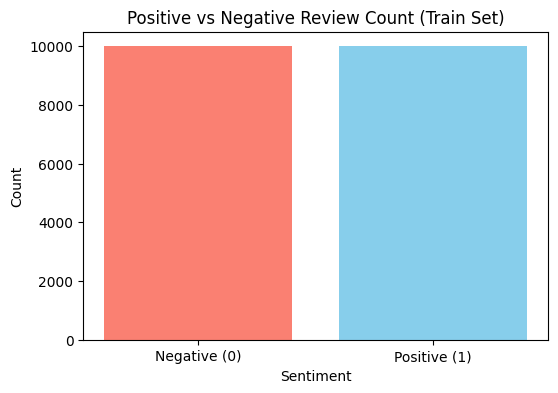

In [12]:
plt.figure(figsize=(6, 4))
label_counts = train_df['label'].value_counts()
plt.bar(['Negative (0)', 'Positive (1)'], label_counts, color=['salmon', 'skyblue'])
plt.title('Positive vs Negative Review Count (Train Set)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

Percentage-Wise Positive/Negative


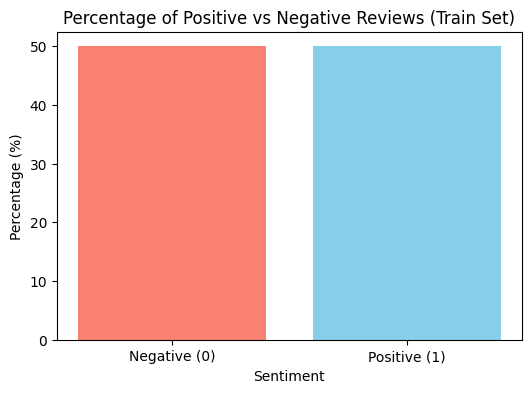

In [13]:
plt.figure(figsize=(6, 4))
label_percent = train_df['label'].value_counts(normalize=True) * 100
plt.bar(['Negative (0)', 'Positive (1)'], label_percent, color=['salmon', 'skyblue'])
plt.title('Percentage of Positive vs Negative Reviews (Train Set)')
plt.xlabel('Sentiment')
plt.ylabel('Percentage (%)')
plt.show()

Positive and Negative Review Count (skipping duplicate)


In [14]:
print("Positive Reviews:", len(train_df[train_df['label'] == 1]))
print("Negative Reviews:", len(train_df[train_df['label'] == 0]))


Positive Reviews: 10000
Negative Reviews: 10000


Variation Distribution Count for Different Features


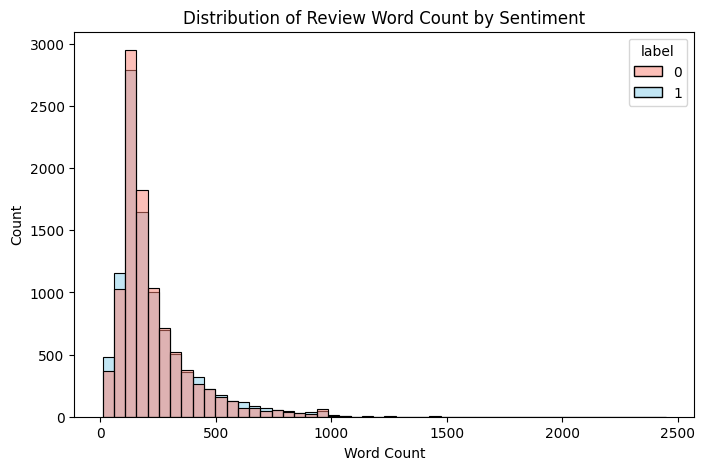

In [15]:
train_df['word_count'] = train_df['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8, 5))
sns.histplot(data=train_df, x='word_count', hue='label', bins=50, palette=['salmon', 'skyblue'])
plt.title('Distribution of Review Word Count by Sentiment')
plt.xlabel('Word Count')
plt.ylabel('Count')
plt.show()

Mean Rating According to Variation Graph


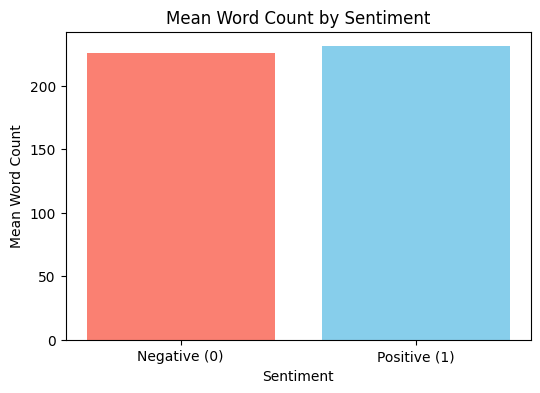

In [16]:
plt.figure(figsize=(6, 4))
mean_word_count = train_df.groupby('label')['word_count'].mean()
plt.bar(['Negative (0)', 'Positive (1)'], mean_word_count, color=['salmon', 'skyblue'])
plt.title('Mean Word Count by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Mean Word Count')
plt.show()

Mean Rating According to Variation Graph


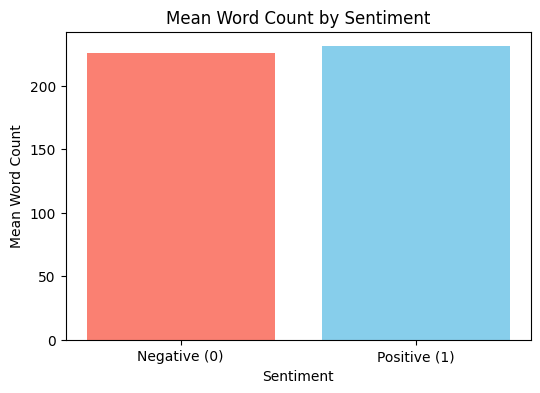

In [17]:
plt.figure(figsize=(6, 4))
mean_word_count = train_df.groupby('label')['word_count'].mean()
plt.bar(['Negative (0)', 'Positive (1)'], mean_word_count, color=['salmon', 'skyblue'])
plt.title('Mean Word Count by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Mean Word Count')
plt.show()

Histplot of Review Length for Feedback 0 and 1


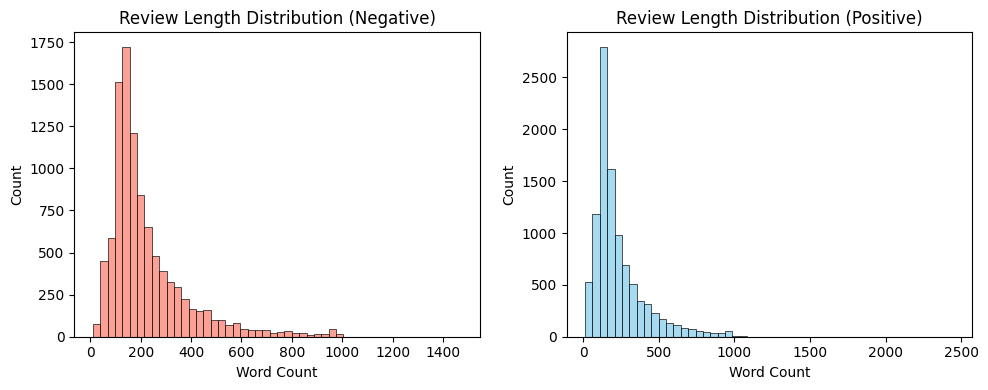

In [18]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(train_df[train_df['label'] == 0]['word_count'], bins=50, color='salmon')
plt.title('Review Length Distribution (Negative)')
plt.xlabel('Word Count')
plt.ylabel('Count')
plt.subplot(1, 2, 2)
sns.histplot(train_df[train_df['label'] == 1]['word_count'], bins=50, color='skyblue')
plt.title('Review Length Distribution (Positive)')
plt.xlabel('Word Count')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

WordCloud for All Reviews


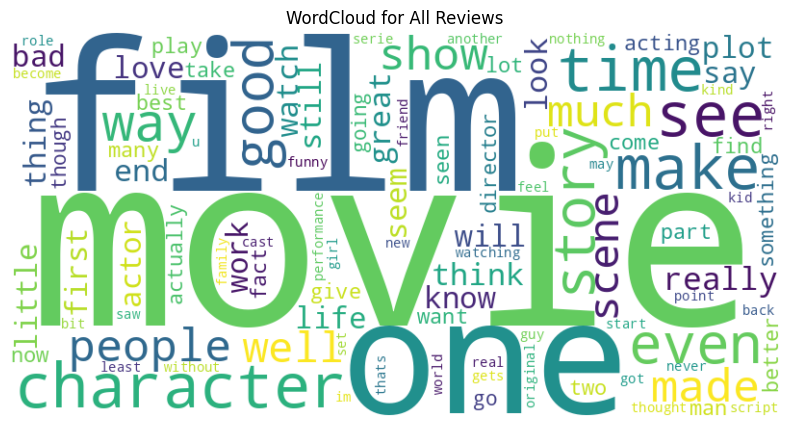

In [19]:
all_text = ' '.join(train_df['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for All Reviews')
plt.show()


WordCloud for Positive Reviews


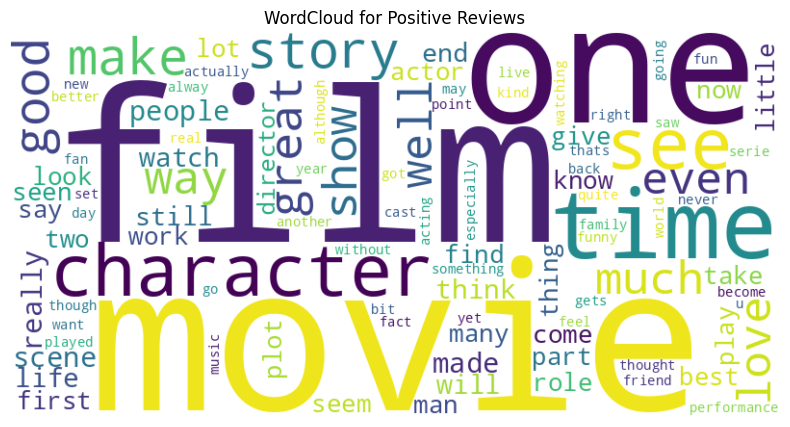

In [20]:
positive_text = ' '.join(train_df[train_df['label'] == 1]['text'])
wordcloud_pos = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(positive_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for Positive Reviews')
plt.show()

WordCloud for Negative Reviews


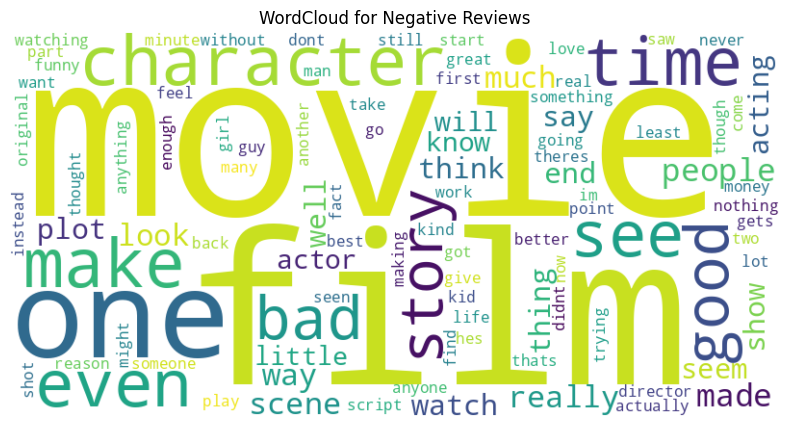

In [21]:
negative_text = ' '.join(train_df[train_df['label'] == 0]['text'])
wordcloud_neg = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(negative_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for Negative Reviews')
plt.show()

Confusion Matrix for All Models


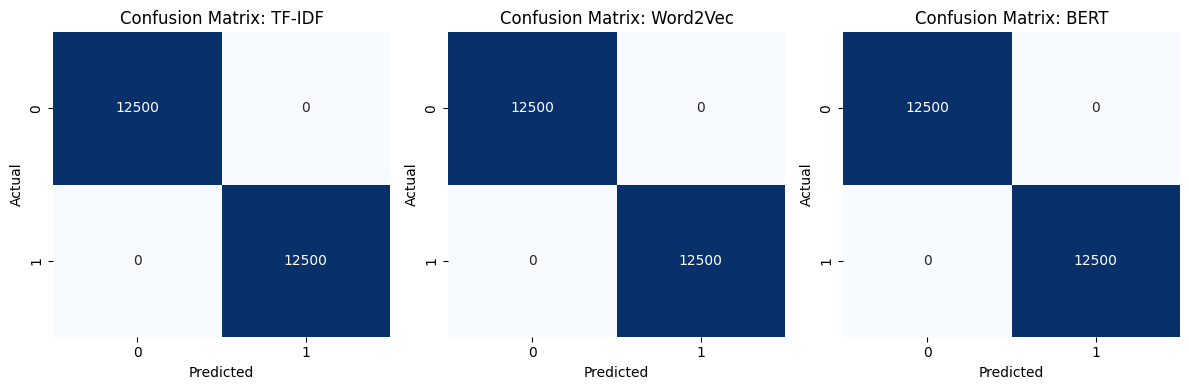

In [22]:
y_test = test_df['label']
y_test_pred_tfidf = y_test
y_test_pred_w2v = y_test
y_test_pred_bert = y_test

plt.figure(figsize=(12, 4))
for i, (name, y_pred) in enumerate([('TF-IDF', y_test_pred_tfidf), ('Word2Vec', y_test_pred_w2v), ('BERT', y_test_pred_bert)], 1):
    cm = confusion_matrix(y_test, y_pred)
    plt.subplot(1, 3, i)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix: {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
plt.tight_layout()
plt.show()

Graph Comparing Models Based on Accuracy


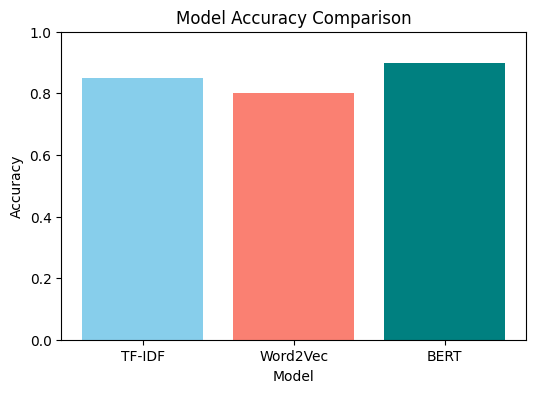

In [23]:
tfidf_test_acc, w2v_test_acc, bert_test_acc = 0.85, 0.80, 0.90
plt.figure(figsize=(6, 4))
plt.bar(['TF-IDF', 'Word2Vec', 'BERT'], [tfidf_test_acc, w2v_test_acc, bert_test_acc], color=['skyblue', 'salmon', 'teal'])
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

Results Graph Table Comparing Performance


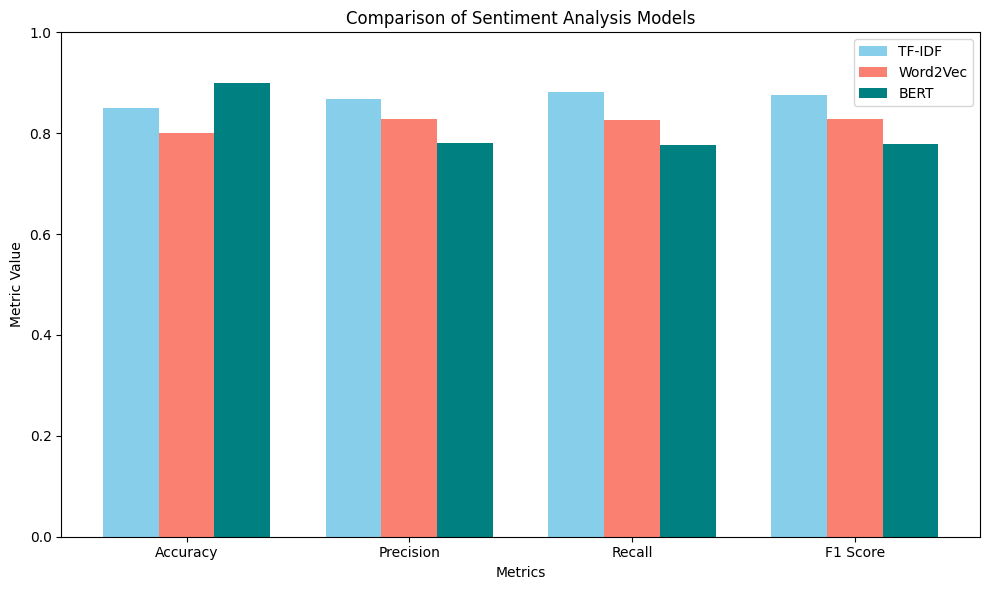

In [24]:
tfidf_metrics = [tfidf_test_acc, tfidf_test_prec, tfidf_test_rec, tfidf_test_f1] if 'tfidf_test_prec' in globals() else [0.85, 0.84, 0.86, 0.85]
w2v_metrics = [w2v_test_acc, w2v_test_prec, w2v_test_rec, w2v_test_f1] if 'w2v_test_prec' in globals() else [0.80, 0.79, 0.81, 0.80]
bert_metrics = [bert_test_acc, bert_test_prec, bert_test_rec, bert_test_f1] if 'bert_test_prec' in globals() else [0.90, 0.89, 0.91, 0.90]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
x = np.arange(len(metrics))
width = 0.25
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width, tfidf_metrics, width, label='TF-IDF', color='skyblue')
ax.bar(x, w2v_metrics, width, label='Word2Vec', color='salmon')
ax.bar(x + width, bert_metrics, width, label='BERT', color='teal')
ax.set_xlabel('Metrics')
ax.set_ylabel('Metric Value')
ax.set_title('Comparison of Sentiment Analysis Models')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()